In [2]:
import os

import random
import cv2
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt 

In [3]:
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 150

train_ds = keras.utils.image_dataset_from_directory(
    directory="dataset/train",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.15,
    subset='training'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="dataset/test",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory="dataset/train",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.15,
    subset='validation'
)

Found 8005 files belonging to 2 classes.
Using 6805 files for training.
Found 2023 files belonging to 2 classes.


2025-02-03 11:50:22.947252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-03 11:50:22.947445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-03 11:50:22.947561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 8005 files belonging to 2 classes.
Using 1200 files for validation.


In [4]:
cnt_imgs = 16  # we take 8 images for each class
cat_path = 'dataset/train/cats'
dog_path = 'dataset/train/dogs'
cat_imgs = os.listdir(cat_path)[:cnt_imgs]
dog_imgs = os.listdir(dog_path)[:cnt_imgs]

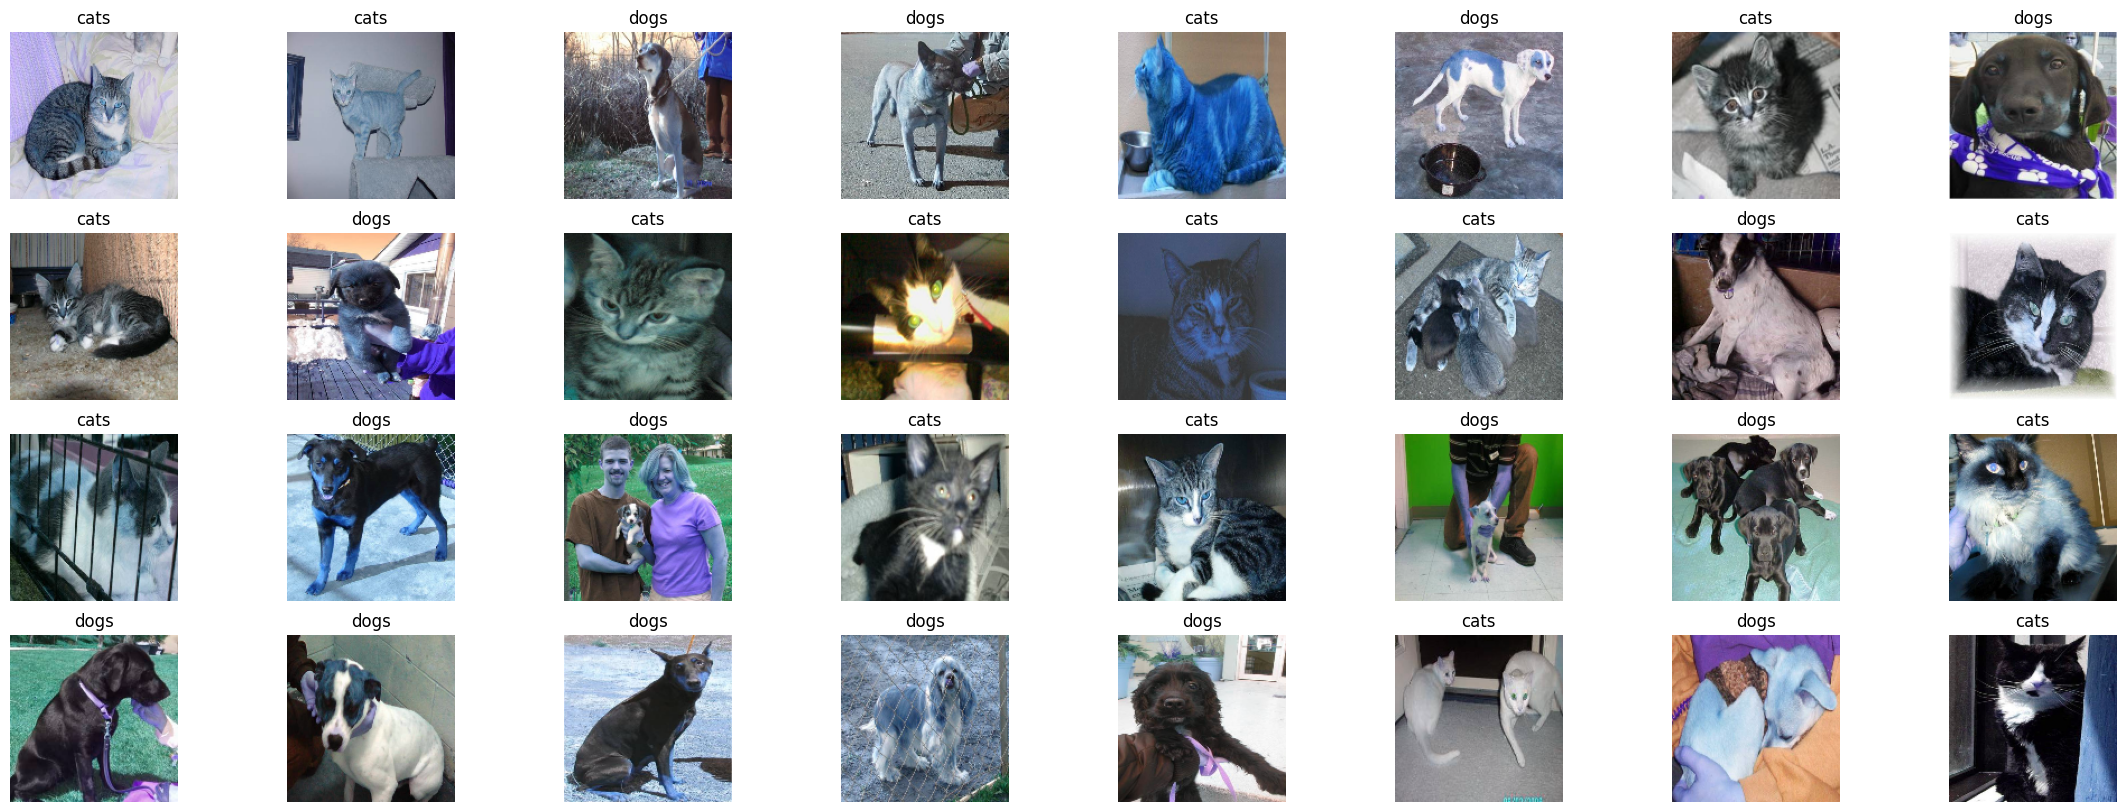

In [5]:
counter = 0
cat_imgs_path = [cat_path + '/' + i for i in cat_imgs]
dog_imgs_path = [dog_path + '/' + j for j in dog_imgs]
all_imgs = cat_imgs_path + dog_imgs_path
random.shuffle(all_imgs)

plt.figure(figsize=(28, 10))
for img_path in all_imgs:
    plt.subplot(4, 8, counter + 1)
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMAGE_SIZE)
    label = img_path[len('dataset/train') + 1: img_path.rfind('/')]
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    counter += 1



In [6]:
def check_cnt_label(label: str) -> int:
    """A function that should determine the number of objects of this
    class in the specified directories"""
    cnt_object = 0
    paths = ['dataset/train', 'dataset/test']
    for path in paths:
        path += '/' + label
        cnt_object += len(os.listdir(path))
    return cnt_object

CNT_CAT = check_cnt_label('cats')
CNT_DOG = check_cnt_label('dogs')

print(f'cats: {CNT_CAT} dogs: {CNT_DOG}')

cats: 5013 dogs: 5019


In [7]:
rescale = keras.layers.Rescaling(scale=1.0 / 255)

train_ds = train_ds.map(lambda image, label: (rescale(image), label))

valid_ds  = valid_ds.map(lambda image, label: (rescale(image), label))

test_ds = test_ds.map(lambda image, label: (rescale(image), label))

In [8]:
CALLBACKS = [
    keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=7, verbose=1),  
    keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=2, verbose=1, mode='auto')
]

In [9]:
inputs = keras.layers.Input(shape=(IMAGE_SIZE + (3,)))

x = keras.layers.Conv2D(32, (3, 3), activation='elu')(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, (3, 3), activation='elu')(x)
block_1_output = keras.layers.MaxPool2D(pool_size=(3, 3))(x)

x = keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same')(block_1_output)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same')(x)
block_2_output = keras.layers.add([x, block_1_output])

x = keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same')(block_2_output)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same')(x)
block_3_output = keras.layers.add([x, block_2_output])

x = keras.layers.Conv2D(128, (3, 3), activation='elu')(block_3_output)
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation='elu')(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)

In [10]:
model = keras.Model(inputs, output)
model.compile(metrics=['Accuracy'], loss='binary_crossentropy', optimizer='Adam')

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 148, 148, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 148, 148, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 146, 146, 64)         18496     ['batch_normalization[0][0

In [12]:
history = model.fit(train_ds, epochs=35, validation_data=valid_ds, callbacks=CALLBACKS)

Epoch 1/35


2025-02-03 11:50:27.485370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8801
2025-02-03 11:50:29.488075: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0034019740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-03 11:50:29.488098: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2025-02-03 11:50:29.488102: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2025-02-03 11:50:29.491409: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-03 11:50:29.586622: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-02-03 11:50:31.

46/46 [==============================] - 24s 344ms/step - loss: 0.7034 - Accuracy: 0.5788 - val_loss: 0.6812 - val_Accuracy: 0.5417 - lr: 0.0010
Epoch 2/35
46/46 [==============================] - 14s 298ms/step - loss: 0.6502 - Accuracy: 0.6103 - val_loss: 0.7527 - val_Accuracy: 0.4917 - lr: 0.0010
Epoch 3/35
46/46 [==============================] - 14s 301ms/step - loss: 0.6273 - Accuracy: 0.6379 - val_loss: 0.7452 - val_Accuracy: 0.4917 - lr: 0.0010
Epoch 4/35
46/46 [==============================] - 14s 300ms/step - loss: 0.6062 - Accuracy: 0.6676 - val_loss: 0.7816 - val_Accuracy: 0.4917 - lr: 0.0010
Epoch 5/35
46/46 [==============================] - 14s 299ms/step - loss: 0.5727 - Accuracy: 0.6935 - val_loss: 0.9666 - val_Accuracy: 0.4925 - lr: 0.0010
Epoch 6/35
46/46 [==============================] - 14s 300ms/step - loss: 0.5394 - Accuracy: 0.7278 - val_loss: 0.8755 - val_Accuracy: 0.4983 - lr: 0.0010
Epoch 7/35
46/46 [==============================] - 14s 301ms/step - loss: 

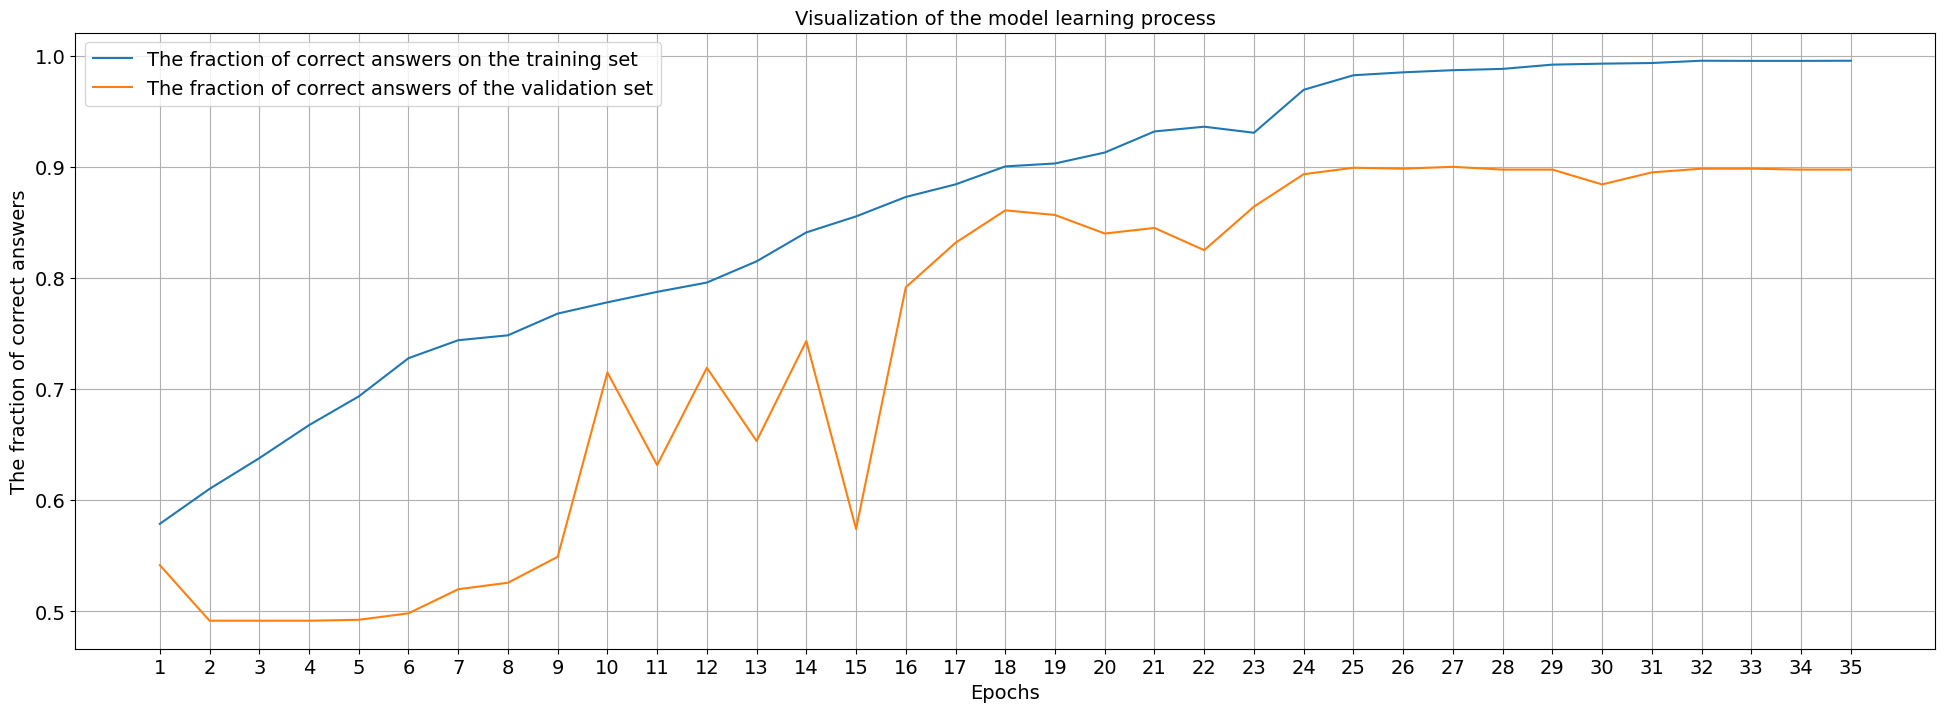

In [209]:
plt.figure(figsize=(24, 8))
plt.title('Visualization of the model learning process', fontsize=14)
plt.plot(np.arange(1, 36), history.history['Accuracy'], label='The fraction of correct answers on the training set') 
plt.plot(np.arange(1, 36), history.history['val_Accuracy'], label='The fraction of correct answers of the validation set')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('The fraction of correct answers', fontsize=14)
plt.xticks(np.arange(1, 36), fontsize=14)
plt.yticks(fontsize=14)
# plt.xlim(1, 36/)
plt.grid()
plt.legend(fontsize=14)
plt.show()

In [208]:
test_result = model.evaluate(test_ds, verbose=0)[1]
train_result = model.evaluate(valid_ds, verbose=0)[1]
print(f'Metric on test: {test_result}')
print(f'Metric on train: {train_result}')

Metric on test: 0.8981710076332092
Metric on train: 0.8974999785423279


In [33]:
model.save('model.keras')

In [158]:
test_ds_as_list = list(test_ds.unbatch().as_numpy_iterator())

In [163]:
test_images = [d[0] for d in test_ds_as_list]

In [183]:
predictions = model.predict(np.array(test_images), verbose=0)
all_predictions = []
wrong_predictions = 0
for i in range(len(predictions)):
    p = 0 if predictions[i] < 0.5 else 1
    rp = test_ds_as_list[i][1]
    if p != rp:
        wrong_predictions += 1
    all_predictions.append([test_images[i], p, rp])

In [184]:
print(f'Test images count - {len(test_ds_as_list)} a number of false prediction - {wrong_predictions}')

Test images count - 2023 a number of false prediction - 206


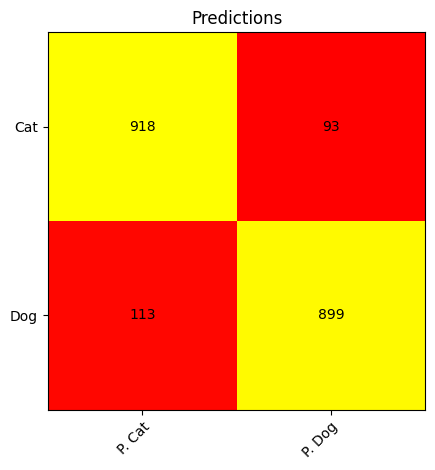

In [203]:

names1 = ["P. Cat", "P. Dog"]
names2 = ["Cat", "Dog"]

correct_cats = len([p for p in all_predictions if p[2] == 0 and p[1] == p[2]])
cat_predict_dog = len([p for p in all_predictions if p[2] == 0 and p[1] == 1])
correct_dogs = len([p for p in all_predictions if p[2] == 1 and p[1] == p[2]])
dog_predict_cat = len([p for p in all_predictions if p[2] == 1 and p[1] == 0])

harvest = np.array([
    [correct_cats, cat_predict_dog],
    [dog_predict_cat, correct_dogs]
])


fig, ax = plt.subplots()
im = ax.imshow(harvest, cmap='autumn')

ax.set_xticks(range(len(names1)), labels=names1, rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(names2)), labels=names2)

for i in range(2):
    for j in range(2):
        text = ax.text(j, i, harvest[i, j],ha="center", va="center", color="black")

ax.set_title("Predictions")
fig.tight_layout()
plt.show()